In this file, we show how to use the utility functions to run cross validation based on test sequence, and explore if we could improve the performance by seperating the data based on the operation mode.

In utility.py, we define a function `run_cv_one_motor` to run cross validation for a specified motor. To check how to use this function, you can have a look at its function signature and documents (put your mouse on the function name in VS Code will show the document).

In this analysis, we use the dataset from motor 6, where we have the following operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'

We will train a model for each operation mode, and compare the results by mixing all the operation modes together.

From this notebook, you should be able to:
- Understand how to use the utility functions to run cross validation.
- Have some insights about how to improve the performance of the model:
    - Should we select the features?
    - Should we seperate operation modes?
    - Should we consider the history in the prediciton as well?
    - Should we consider further pre-processing of the data to consider more features regarding the time-series?
        - Adjust for sequence-to-sequence variablity by subtracting the initial values?
        - Add features relating the change velocity?

In [1]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


# Subfunction for data preprocessing.
def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Demo: How to use the utility function for cross validation.

## Basic usage

We can use `run_cv_one_motor` to easily run cross validation for one motor. For details of how to use this function, please have a look at its function signature (put your mouse on the function name will show the function signature). 

In the basic mode, we only need to specify values to four variables: `motor_idx, df_data, mdl, feature_list`.

For example, we could run a seven-fold cross validation with a logistic regression model using the following code:

Model for motor 6:

 New run:

training performance, accuracy is: 0.898394495412844
training performance, precision is: 0.802924791086351
training performance, recall: 0.8781416603198782
training performance, F1: 0.8388504910876682



 New run:

testing performance, accuracy is: 0.4231809981960313
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




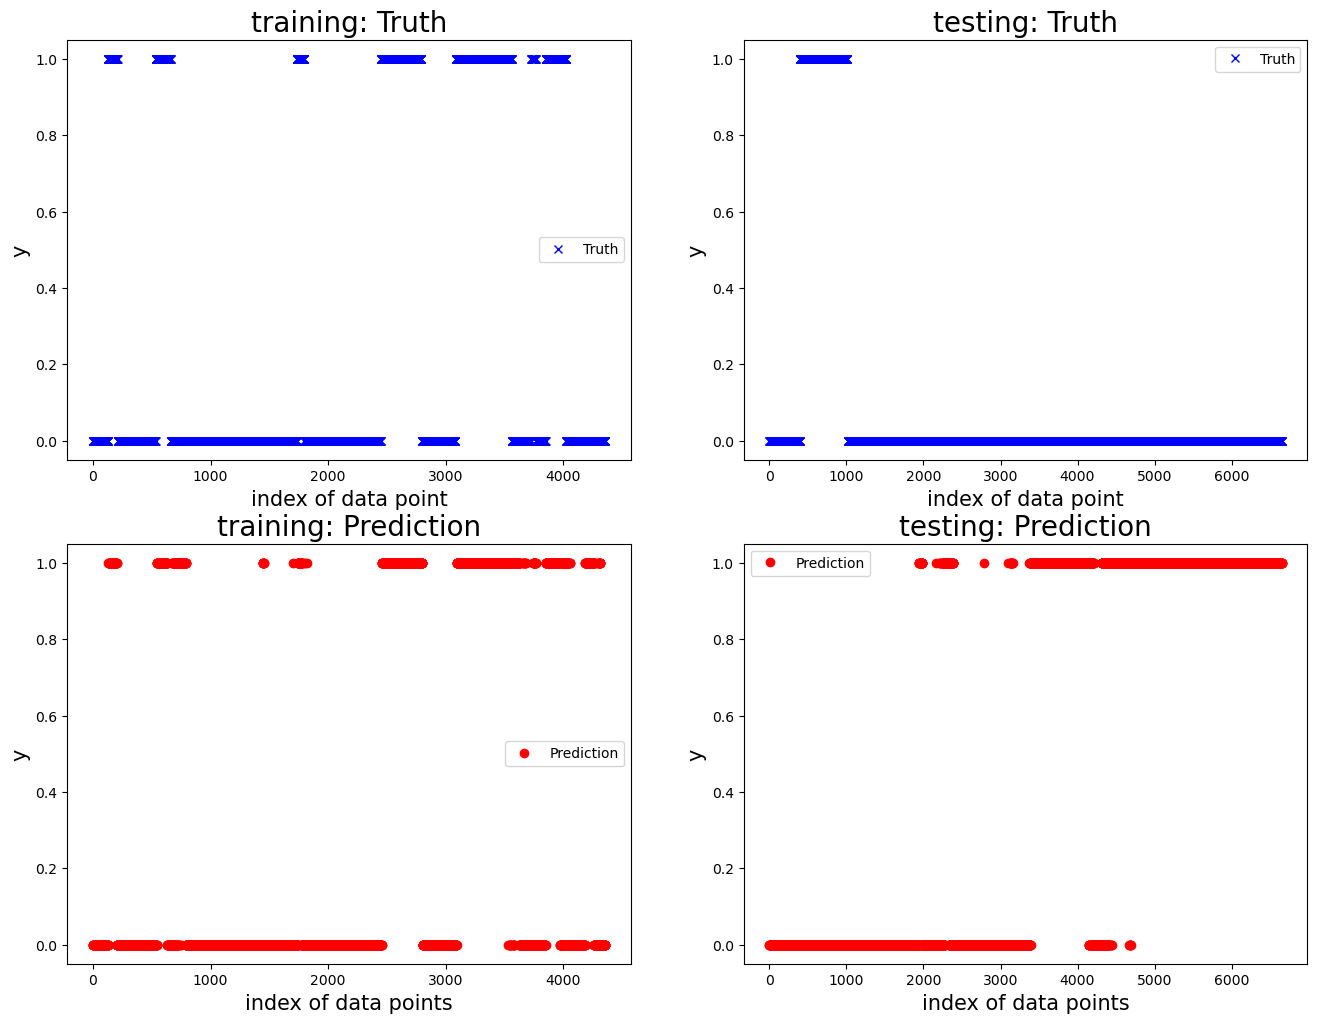


 New run:

training performance, accuracy is: 0.8796030052870791
training performance, precision is: 0.5969782150386508
training performance, recall: 0.9183783783783783
training performance, F1: 0.7235945485519591



 New run:

testing performance, accuracy is: 0.354978354978355
testing performance, precision is: 0.354978354978355
testing performance, recall: 1.0
testing performance, F1: 0.5239616613418531




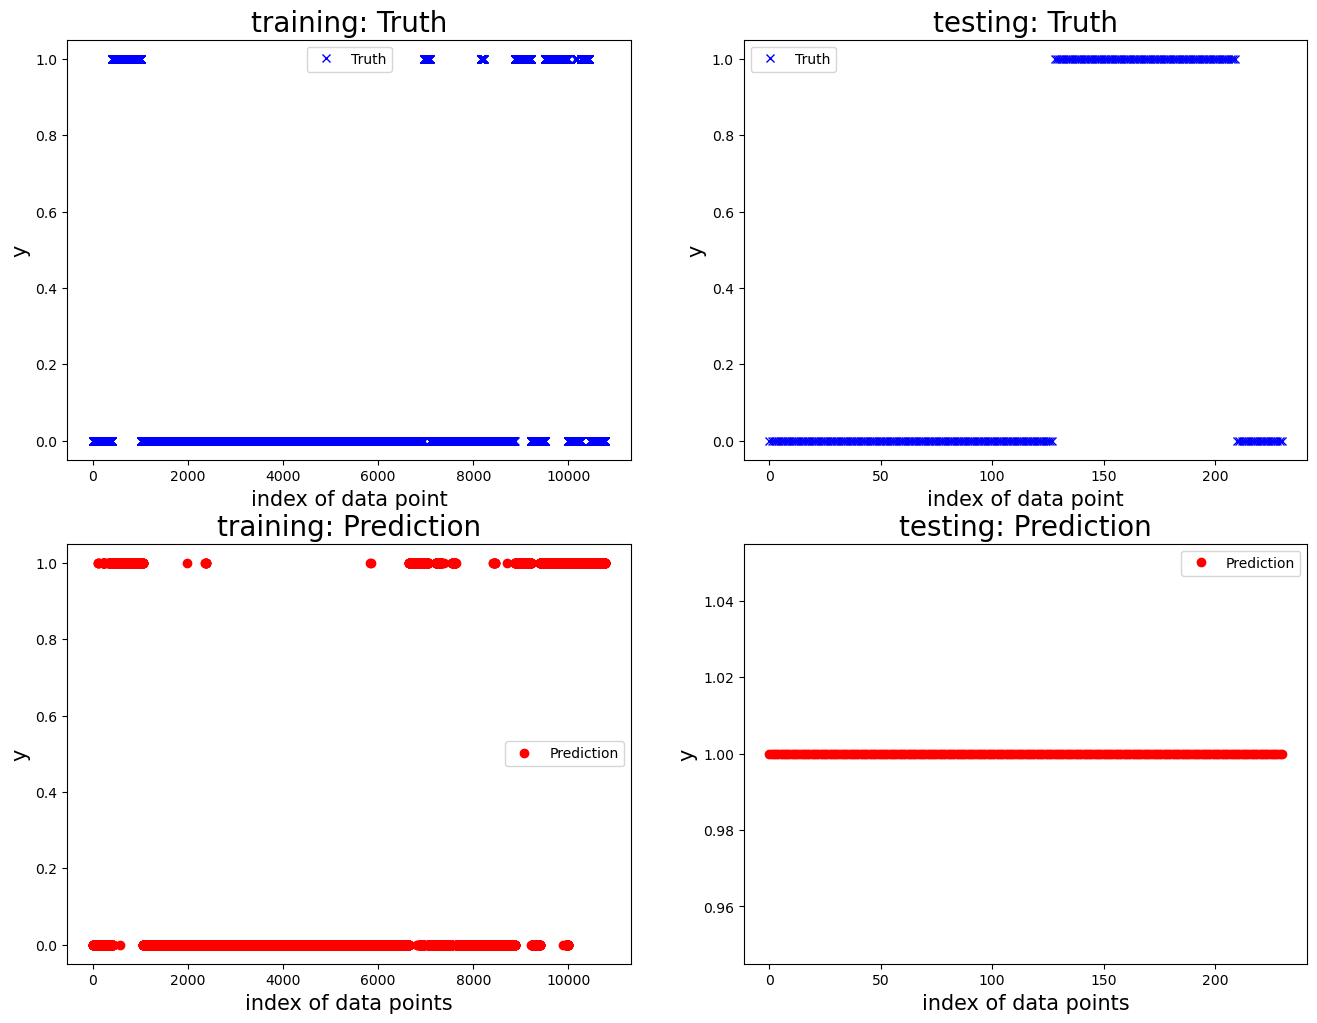


 New run:

training performance, accuracy is: 0.8958094144661309
training performance, precision is: 0.6342105263157894
training performance, recall: 0.9356627842484747
training performance, F1: 0.7559937261931435



 New run:

testing performance, accuracy is: 0.7696428571428572
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




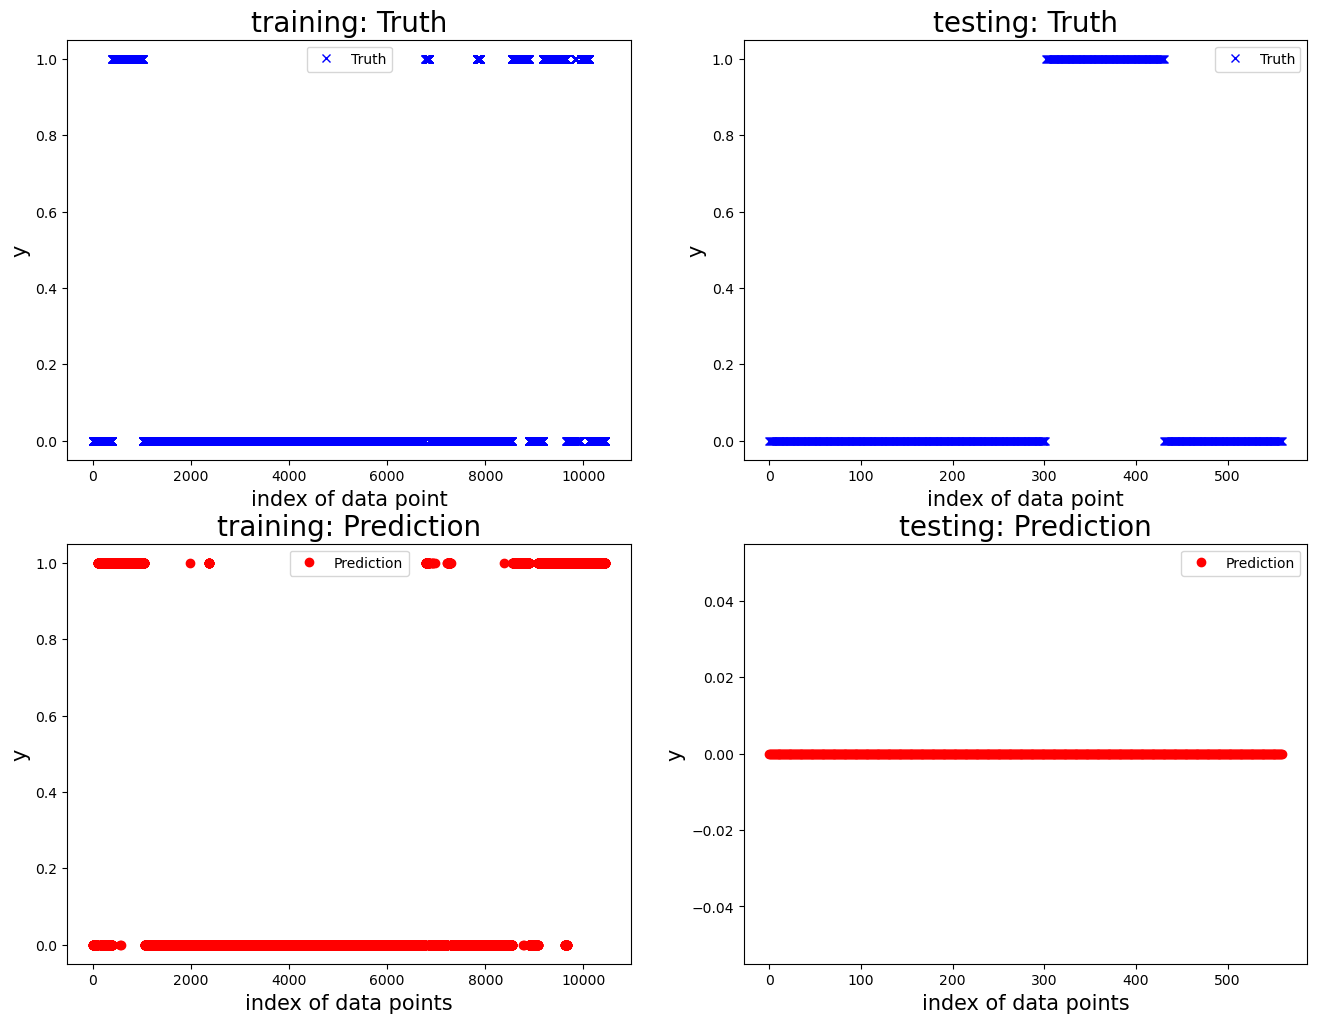


 New run:

training performance, accuracy is: 0.8839285714285714
training performance, precision is: 0.6279654924514737
training performance, recall: 0.9347244515783841
training performance, F1: 0.7512362932702643



 New run:

testing performance, accuracy is: 0.0603448275862069
testing performance, precision is: 0.0603448275862069
testing performance, recall: 1.0
testing performance, F1: 0.11382113821138212




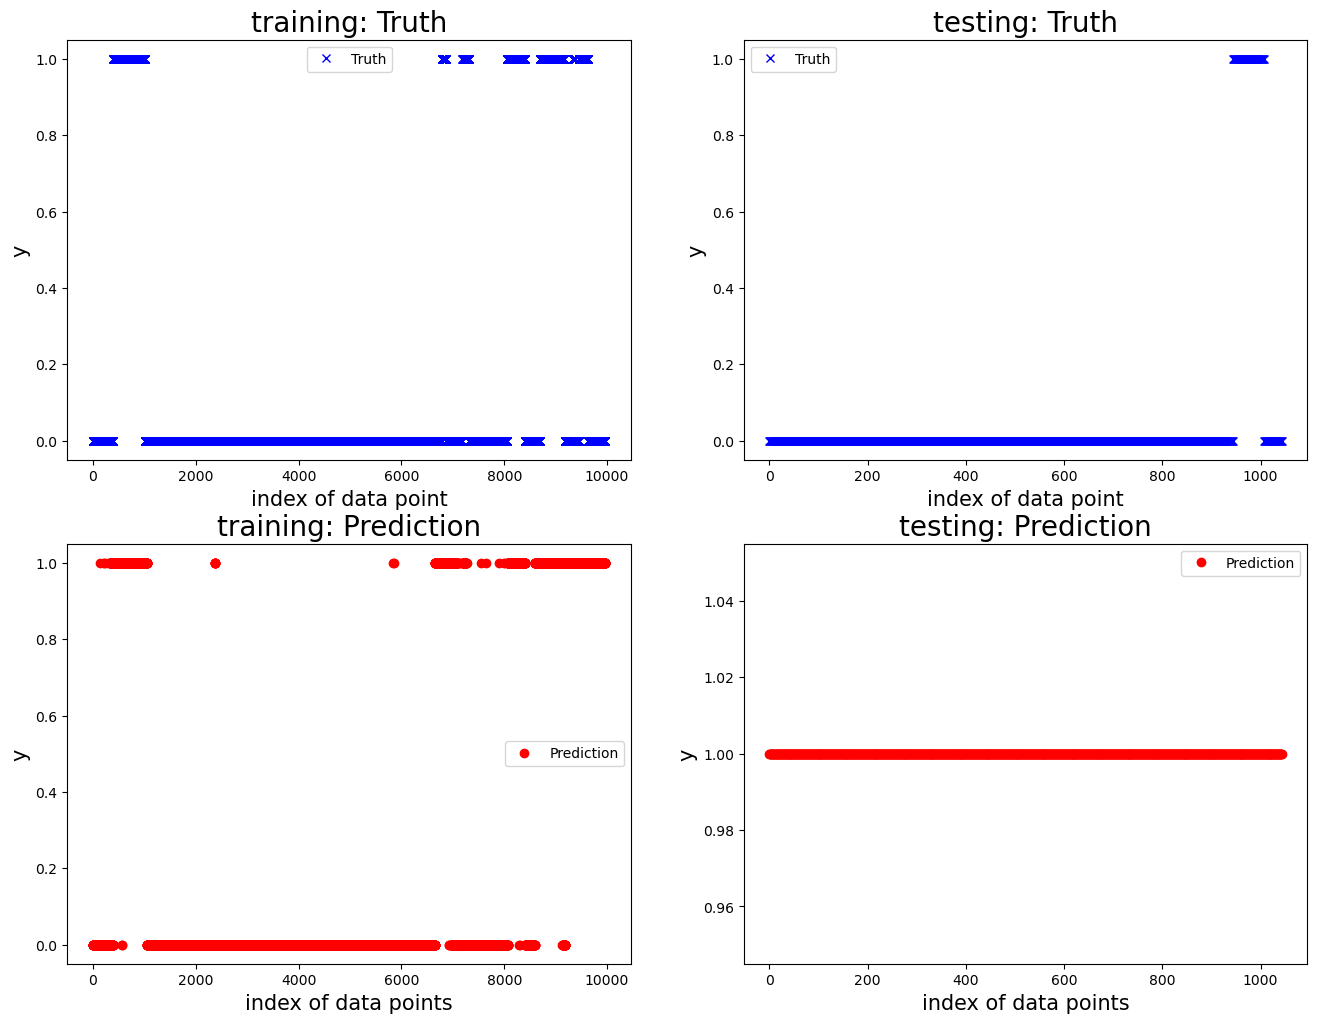


 New run:

training performance, accuracy is: 0.8211497515968772
training performance, precision is: 0.47216174183514775
training performance, recall: 0.9577287066246056
training performance, F1: 0.6325000000000001



 New run:

testing performance, accuracy is: 0.5926892950391645
testing performance, precision is: 0.0
testing performance, recall: 0.0
testing performance, F1: 0.0




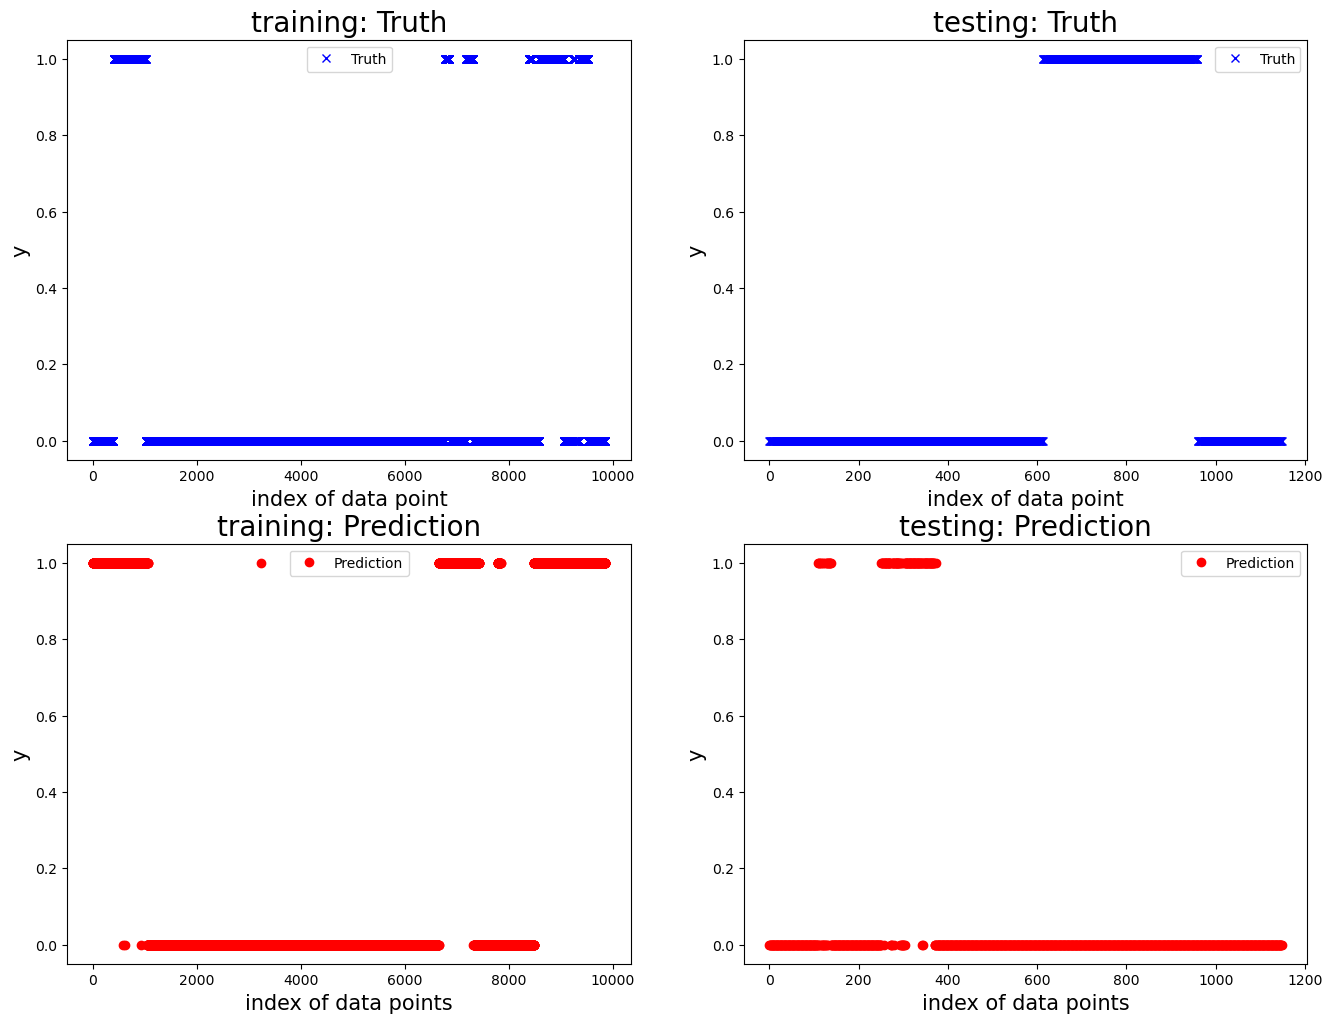


 New run:

training performance, accuracy is: 0.808124459809853
training performance, precision is: 0.4169202678027998
training performance, recall: 0.9435261707988981
training performance, F1: 0.5783030814689742



 New run:

testing performance, accuracy is: 0.9148580968280468
testing performance, precision is: 0.9820224719101124
testing performance, recall: 0.9104166666666667
testing performance, F1: 0.9448648648648649




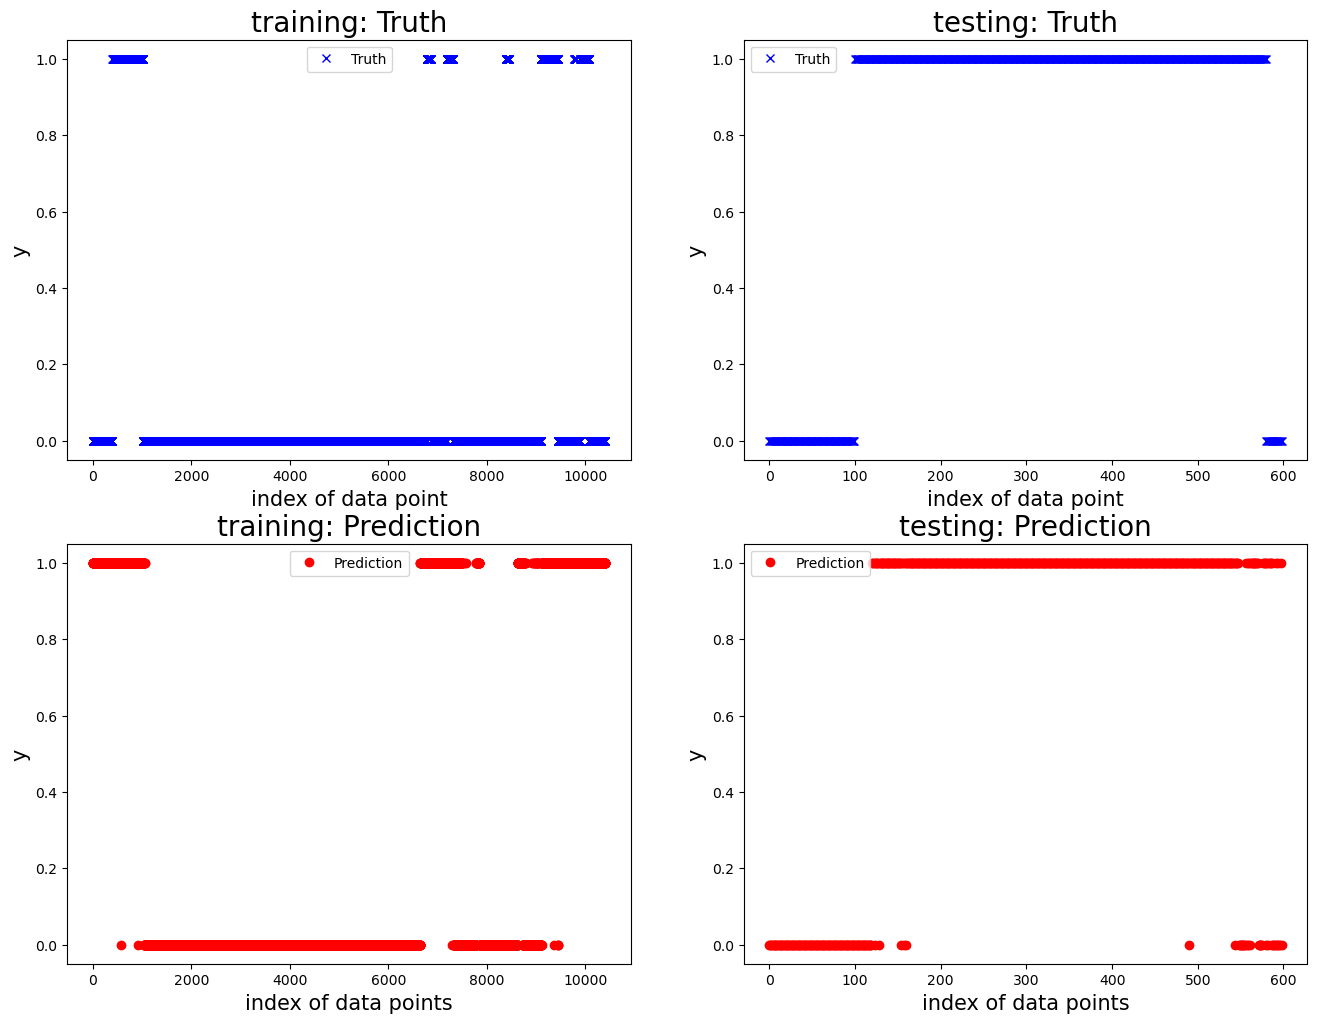


 New run:

training performance, accuracy is: 0.8073277967757694
training performance, precision is: 0.46089385474860334
training performance, recall: 0.8633720930232558
training performance, F1: 0.6009712666936463



 New run:

testing performance, accuracy is: 0.2728442728442728
testing performance, precision is: 0.2728442728442728
testing performance, recall: 1.0
testing performance, F1: 0.4287158746208291




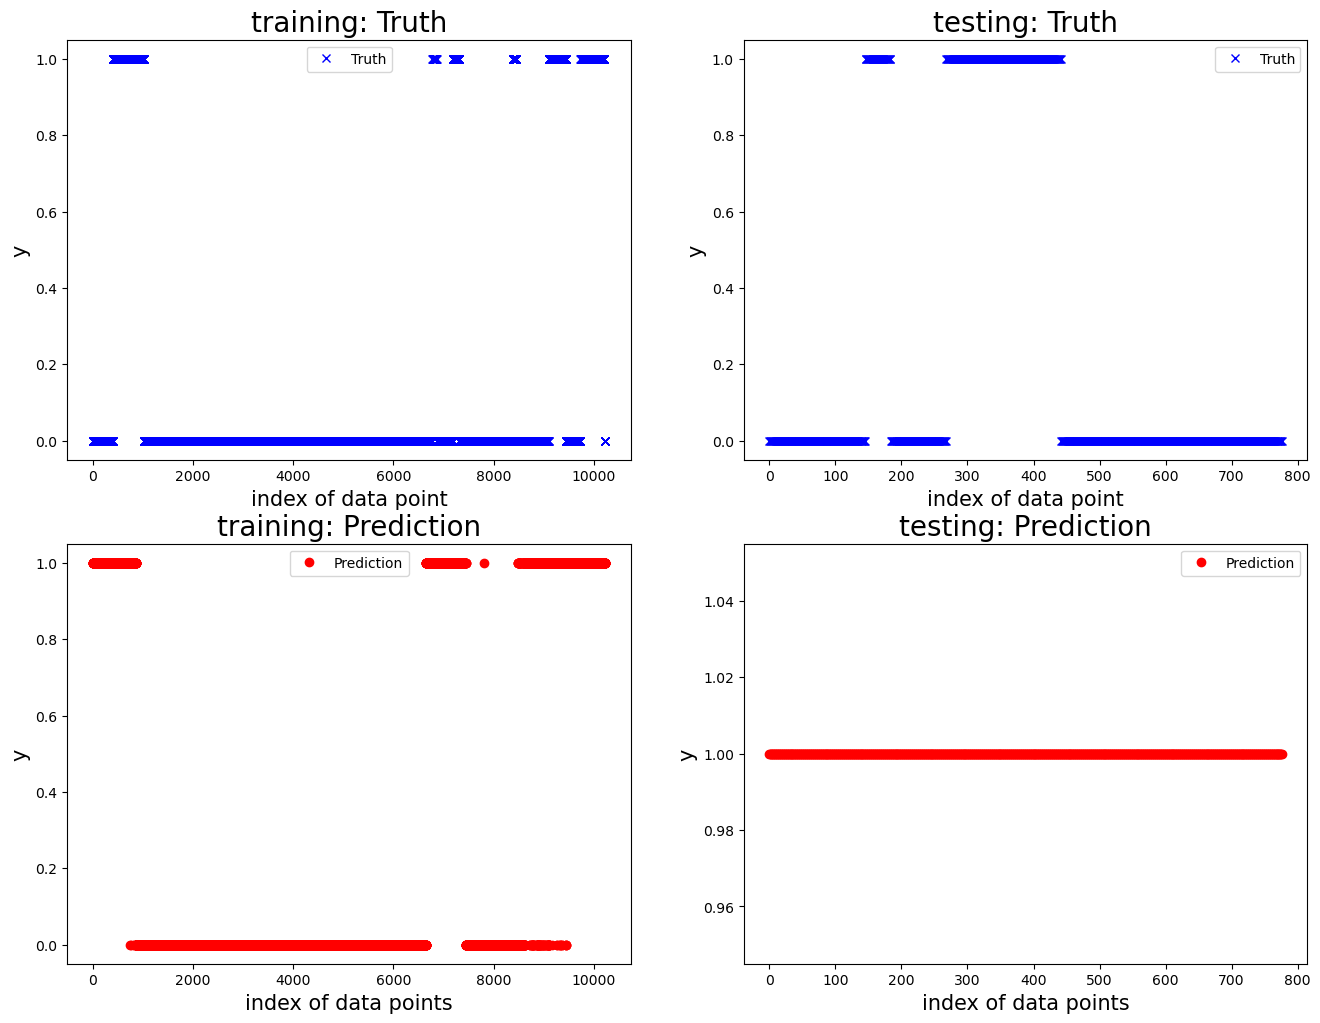

   Accuracy  Precision    Recall  F1 score
0  0.423181   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.769643   0.000000  0.000000  0.000000
3  0.060345   0.060345  1.000000  0.113821
4  0.592689   0.000000  0.000000  0.000000
5  0.914858   0.982022  0.910417  0.944865
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4841 +- 0.2954
Precision: 0.2386 +- 0.3582
Recall: 0.5586 +- 0.5235
F1 score: 0.2873 +- 0.3620




In [2]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv)


For each run in the cross validation, the function shows the performance on the training and testing dataset. This can be used for diagnosis and improving the model performance. In the end, the mean performance is printed. 

If you set the parameter `single_run_result=False`, only the final average performance is printed. Plesae note that in the final printed result, we print the mean value and the error bar of the performance metrics. The error bars are calculated as one standard deviation over all the runs.

## Select the features

You can choose other features by changing the `feature_list`. Below you can find a demo for using only part of the features.

In [3]:
# Define the features.
feature_list_selected = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 
                    'data_motor_2_position', 'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 
                    'data_motor_4_position', 'data_motor_4_temperature', 
                    'data_motor_5_position', 'data_motor_5_temperature', 
                    'data_motor_6_position', 'data_motor_6_temperature']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_selected, n_fold=n_cv, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.290439   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.769643   0.000000  0.000000  0.000000
3  0.386973   0.011844  0.111111  0.021407
4  0.637076   0.000000  0.000000  0.000000
5  0.781302   1.000000  0.727083  0.841978
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4990 +- 0.2236
Precision: 0.2342 +- 0.3689
Recall: 0.4055 +- 0.4814
F1 score: 0.2594 +- 0.3407




## Increase the feature space by concatenating the features in the past

Additionaly, we can use this program to generate new features by concatenating the features in the past by defining a sliding window. For doing this, you need to use the following parameters:
- window_size: the size of the sliding window. The features in the sliding window are concanetated into a feature vector.
- sample_step: we allow taking features every `sample_step` data points.

Below is a demo of taking every $10$ points in a past interval of $50$ points to create new features and make prediction. You can explore different values of `window_size` and `sample_step` to see how the performance changes.

In [4]:
window_size = 50
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision   Recall  F1 score
0  0.294047   0.000000  0.00000  0.000000
1  0.354978   0.354978  1.00000  0.523962
2  0.769643   0.000000  0.00000  0.000000
3  0.066092   0.060694  1.00000  0.114441
4  0.548303   0.000000  0.00000  0.000000
5  0.654424   1.000000  0.56875  0.725100
6  0.272844   0.272844  1.00000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4229 +- 0.2452
Precision: 0.2412 +- 0.3644
Recall: 0.5098 +- 0.5007
F1 score: 0.2560 +- 0.2995




# Seperate operation mode

In the previous analysis, the dataset contains three different operation modes:
- not moving
- pick-up and place
- only moving motor 6.

In this section, we try to seperate the three operation modes, and train a specific model per operation mode. For each operation mode, we further compare:
- window_size=1: only use current measurement V.S. 
- window_size=50 and sample_step=10: use 50 previous points and sample every 10 points as features.

Let's start by defining a supporting function.

In [5]:
from utility import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size=1, sample_step=1, n_fold=5):
    print(f'window_size={window_size}, sample_step={sample_step}, all the features.')
    feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, sample_step={sample_step}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

## Not moving

In [6]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.935065   0.876404  0.951220  0.912281
1  0.723214   0.453571  0.984496  0.621027
2  0.965517   0.775510  0.603175  0.678571


Mean performance metric and standard error:
Accuracy: 0.8746 +- 0.1320
Precision: 0.7018 +- 0.2208
Recall: 0.8463 +- 0.2112
F1 score: 0.7373 +- 0.1543


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.961039   1.000000  0.890244  0.941935
1  0.551786   0.339474  1.000000  0.506876
2  0.060345   0.060345  1.000000  0.113821


Mean performance metric and standard error:
Accuracy: 0.5244 +- 0.4510
Precision: 0.4666 +- 0.4826
Recall: 0.9634 +- 0.0634
F1 score: 0.5209 +- 0.4142


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.363636   0.358079  1.000000  0.527331
1  0.798214   0.543011  0.782946  0.641270
2  0.060

## Move only motor 6.

In [7]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

# Windowsize = 1.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.198664   0.000000  0.000000  0.000000
1  0.512227   0.011696  0.009434  0.010444


Mean performance metric and standard error:
Accuracy: 0.3554 +- 0.2217
Precision: 0.0058 +- 0.0083
Recall: 0.0047 +- 0.0067
F1 score: 0.0052 +- 0.0074


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision   Recall  F1 score
0  0.634391   1.000000  0.54375  0.704453
1  0.272844   0.272844  1.00000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4536 +- 0.2557
Precision: 0.6364 +- 0.5142
Recall: 0.7719 +- 0.3226
F1 score: 0.5666 +- 0.1950


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.198664   0.000000  0.000000  0.000000
1  0.308880   0.280702  0.981132  0.436516


Mean performance metric and standard error:
Accuracy: 0.2538 +- 0.0779
Precision: 0.1404 +- 0.1

## Pick up and place

In [8]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

# Windowsize = 0.
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, n_fold=n_cv)

# Windowsize = 5.
window_size = 50
sample_step = 10
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, sample_step=sample_step, n_fold=n_cv)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093055   0.093055     1.0  0.170265
1  0.697998   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3955 +- 0.4278
Precision: 0.0465 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0851 +- 0.1204


window_size=1, sample_step=1, randomly pick features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093055   0.093055  1.000000  0.170265
1  0.266319   0.276173  0.881844  0.420619


Mean performance metric and standard error:
Accuracy: 0.1797 +- 0.1225
Precision: 0.1846 +- 0.1295
Recall: 0.9409 +- 0.0835
F1 score: 0.2954 +- 0.1770


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093055   0.093055     1.0  0.170265
1  0.697998   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3955 +- 0.4278
Precision: 0.0465 +- 0.0658
Recal

# Data preprocessing considering the time-series features.

## Remove the sequence-to-sequence variablity.

Since the tests are conducted at different time, we cannot garantee that the test conditions are exactly the same. For example, the environment temperature might be different from one test to another and impacts the temperatures of the motors. An easy way to adjust for this variability is to subtract the first value of each sequence from each value of the sequence.

Below is a simple code that implements this idea.

In [9]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


def compensate_seq_bias(df: pd.DataFrame):
    ''' # Description
    Adjust for the sequence-to-sequence bias.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()        

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()        

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - Adjust for the sequence-to-sequence bias.
    - add new features about the difference between the current and previous n data point.
    '''     
    # Start processing.
    remove_outliers(df)
    compensate_seq_bias(df)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]

We run the same basic test as Sect. 1. It can be seen from the results that after adjusting the sequence-to-sequence variablity, the results improve significantly.

In [10]:
from utility import run_cv_one_motor

# We want a five-fold cross validation.
n_cv = 7
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv, single_run_result=False)


Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.092754   0.091554  0.980614  0.167471
1  0.952381   0.986301  0.878049  0.929032
2  0.860714   1.000000  0.395349  0.566667
3  0.129310   0.064815  1.000000  0.121739
4  0.542211   0.395322  0.974063  0.562396
5  0.899833   0.903846  0.979167  0.940000
6  0.773488   0.687500  0.311321  0.428571


Mean performance metric and standard error:
Accuracy: 0.6072 +- 0.3638
Precision: 0.5899 +- 0.4073
Recall: 0.7884 +- 0.3008
F1 score: 0.5308 +- 0.3261




## Add change dynamics features

Another possiblity is to add features that consider the change dynamics of the measured data. This can be done by defining a variable $n_int$, and calculate the difference between the current and the previous $n_{int}$ data points. For example, if $n_{int} = 1$, the feature $x_{t-1} - x_t$ is added. If $n_{int} = 2$, the feature $x_{t-2} - x_{t-1} - x_t$ is added.

Below is an example that implements this idea.

In [11]:
from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    remove_outliers(df)
    cal_diff(df, n_int)


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Specify the test conditions you would like to include in the test.
df_data_experiment = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
n_cv = 7

In [12]:
from utility import run_cv_one_motor

feature_list_selected = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 
                    'data_motor_2_position', 'data_motor_2_temperature', 
                    'data_motor_3_position', 'data_motor_3_temperature', 
                    'data_motor_4_position', 'data_motor_4_temperature', 
                    'data_motor_5_position', 'data_motor_5_temperature', 
                    'data_motor_6_position', 'data_motor_6_temperature', 
                    'data_motor_1_position_diff', 'data_motor_1_temperature_diff', 
                    'data_motor_2_position_diff', 'data_motor_2_temperature_diff', 
                    'data_motor_3_position_diff', 'data_motor_3_temperature_diff', 
                    'data_motor_4_position_diff', 'data_motor_4_temperature_diff', 
                    'data_motor_5_position_diff', 'data_motor_5_temperature_diff', 
                    'data_motor_6_position_diff', 'data_motor_6_temperature_diff']
window_size = 50
sample_step = 10

all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list_selected, 
            n_fold=n_cv, window_size=window_size, sample_step=sample_step, single_run_result=False)

Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.094089   0.093406  1.000000  0.170853
1  0.905213   1.000000  0.756098  0.861111
2  0.859259   1.000000  0.410853  0.582418
3  0.663086   0.020408  0.095238  0.033613
4  0.590788   0.428748  0.997118  0.599653
5  0.949914   0.961145  0.979167  0.970072
6  0.807133   0.720000  0.509434  0.596685


Mean performance metric and standard error:
Accuracy: 0.6956 +- 0.2949
Precision: 0.6034 +- 0.4256
Recall: 0.6783 +- 0.3516
F1 score: 0.5449 +- 0.3389


